# OriPrint 101 Notebook
### Authors: 
#### - Pietro Lo Riso
#### - Carlo Emanuele Villa

<i> Version 1.0 </i>

---

This notebook reproduces the steps to obtain OriPrint, a DNA methylation signature derived from fimbria and ovarian surface epithelial samples, that allows the stratification of high grade serous ovarian cancer samples based on their tissue of origin.

Reference: <i> "A cell-of-origin epigenetic tracer reveals clinically distinct subtypes of high grade serous ovarian cancer", Lo Riso, Villa et al. 2020, Genome Medicine (DOI) </i>

## Load Libraries

Here we will use:
- the package <b>lumi</b> to convert M-values to Beta-values and <i>viceversa</i>
- the package <b>limma</b> to derive OriPrint's Differentially Methylated Sites (DMS) 
- the package <b>pheatmap</b> to plot the dataset subset by OriPrint

In [1]:
library(limma)
library(lumi)
library(pheatmap)

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    u

## Load Dataset and Annotation

By this step we load the M-values derived from the cohort of 2D cultured samples. This cohort is composed of:
- 12 Fimbria Samples (FI)
- 8 Ovarian Surface Epithelium Samples (OSE)
- 11 Solid High Grade Serous Ovarian Cancer Samples (HGSOC)
- 13 Ascites-derived HGSOC samples (AS)

In [2]:
Dataset = readRDS("data/CellOfOriginDataset.rds")
Annotation = readRDS("data/AnnotationCellOfOrigin.rds")

In [3]:
head(Annotation)
head(Dataset)

ID,SampleType,CellType,TissueType,Status
14-OSE-069,Cells,OSE,OSE,Normal
14-OSE-086,Cells,OSE,OSE,Normal
14-OSE-134,Cells,OSE,OSE,Normal
14-OSE-135,Cells,OSE,OSE,Normal
16-OSE-008,Cells,OSE,OSE,Normal
16-OSE-024,Cells,OSE,OSE,Normal


,14-OSE-069,14-OSE-086,14-OSE-134,14-OSE-135,16-OSE-008,16-OSE-024,13-OSE-013,16-OSE-021,15-FI-047,15-FI-001,⋯,14-AS-014,14-AS-015,14-AS-040,14-AS-042,16-AS-002,16-AS-012,16-AS-013,16-AS-016,15-AS-015,16-AS-020
cg00000029,-1.0229915,-1.5959675,-2.0527617,-1.4042247,-0.84426121,-0.6043892,-3.3530160,-2.9674578,-1.60922786,-0.8947428,⋯,-1.2628941,-1.5043535,-1.5509931,-1.862459,-1.9414769,-1.3357049,-2.553349,-1.516346,-1.4361381,-4.8462980
cg00000109,3.0713992,2.4036680,2.7837737,3.4786822,3.32469700,2.8865321,2.2841224,1.9847569,2.73286692,4.1576267,⋯,1.8495535,2.1884365,2.1659803,2.423753,2.6065104,2.9593013,2.529497,2.633799,1.9678821,4.0660152
cg00000165,-1.7330920,-2.0318350,-1.5305525,-1.4690396,-1.00126899,-1.6204050,-1.9320907,-1.9407660,-0.54383635,-3.4423477,⋯,-2.3457494,-1.6688794,-3.4956400,-1.299199,0.7683352,-0.7933720,-1.909823,-2.659539,-0.9918024,0.7281594
cg00000236,2.3873817,3.4974429,2.7826735,2.8842879,2.99881542,2.8763226,2.0226673,2.6445053,2.73889283,2.6549807,⋯,2.5094417,2.4553970,3.2633670,2.433109,3.6072776,2.1232083,2.501408,2.159099,2.2650426,2.5875098
cg00000289,0.2431322,0.1233708,0.2444518,0.3694636,-0.03886696,0.1520817,3.3152493,0.2280893,-0.01886986,0.1115385,⋯,0.7547506,0.6063159,0.5825371,0.423089,0.2537579,-0.5651919,1.910636,3.189846,1.5548523,-0.1882495
cg00000292,2.3263641,2.1875531,1.7810737,2.3232152,2.04632106,2.7405951,-0.1577236,0.1548107,1.88213811,2.9587746,⋯,1.8151728,1.7655881,1.8714955,1.902720,1.5812300,1.5591267,1.897961,1.226284,2.4786915,-1.0495429


## Generation of OriPrint

By this step we will calculate the Differentially Methylated Sites (DMS) between FI and OSE samples (OriPrint)

Here we are selecting the data related to FI and OSE samples

In [4]:
FIOSESamples = cbind(Dataset[,colnames(Dataset) %in% Annotation[Annotation$CellType == "FI","ID"]],
                     Dataset[,colnames(Dataset) %in% Annotation[Annotation$CellType == "OSE","ID"]]
                    )
head(FIOSESamples)
dim(FIOSESamples)

,15-FI-047,15-FI-001,15-FI-062,14-FI-100,14-FI-102,14-FI-103,14-FI-104,14-FI-110,16-FI-019,16-FI-020,16-FI-009,16-FI-010,14-OSE-069,14-OSE-086,14-OSE-134,14-OSE-135,16-OSE-008,16-OSE-024,13-OSE-013,16-OSE-021
cg00000029,-1.60922786,-0.8947428,-1.34751872,-1.9919950,-1.643088,-1.1566938,-2.3146068,-1.858402,-0.2066225,-0.87118972,-0.1932189,-1.831241,-1.0229915,-1.5959675,-2.0527617,-1.4042247,-0.84426121,-0.6043892,-3.3530160,-2.9674578
cg00000109,2.73286692,4.1576267,3.66137033,2.5908557,2.152544,3.0724202,2.8815983,3.243082,2.9086167,3.55120350,2.8934964,2.393822,3.0713992,2.4036680,2.7837737,3.4786822,3.32469700,2.8865321,2.2841224,1.9847569
cg00000165,-0.54383635,-3.4423477,-1.16644977,-0.1078961,-1.586853,-2.1816820,-2.6083036,-1.099149,-1.9693236,-0.25165961,-0.5712278,-2.254578,-1.7330920,-2.0318350,-1.5305525,-1.4690396,-1.00126899,-1.6204050,-1.9320907,-1.9407660
cg00000236,2.73889283,2.6549807,3.28632317,2.9665465,2.431326,2.2219396,3.2963662,3.179503,3.0651353,2.78208096,3.3759116,2.535258,2.3873817,3.4974429,2.7826735,2.8842879,2.99881542,2.8763226,2.0226673,2.6445053
cg00000289,-0.01886986,0.1115385,0.09267498,0.2633558,0.575155,0.3307126,0.4366407,1.240325,0.3953642,0.06148019,0.4871765,1.285152,0.2431322,0.1233708,0.2444518,0.3694636,-0.03886696,0.1520817,3.3152493,0.2280893
cg00000292,1.88213811,2.9587746,2.61668994,1.6029149,1.158466,1.7081696,1.5079231,2.098223,2.5893519,1.25676622,2.3823947,3.023642,2.3263641,2.1875531,1.7810737,2.3232152,2.04632106,2.7405951,-0.1577236,0.1548107


[1] 418345     20

Now we select generate a reference vector for the groups present in this subset

In [5]:
group = factor(c(rep("FI", dim((Annotation[Annotation$CellType == "FI",]))[1]),
                 rep("OSE", dim((Annotation[Annotation$CellType == "OSE",]))[1])
                )
              )
print(group)

 [1] FI  FI  FI  FI  FI  FI  FI  FI  FI  FI  FI  FI  OSE OSE OSE OSE OSE OSE OSE
[20] OSE
Levels: FI OSE


Here we perform the differential methylation analysis using <b>limma</b>. 

<i>Please note we are using M-Values for this calculation.</i>

In [6]:
design = model.matrix(~group)
top = topTable(eBayes(lmFit(FIOSESamples, design)), 
               number=dim(FIOSESamples)[1])
head(top)
dim(top)

Removing intercept from test coefficients


,logFC,AveExpr,t,P.Value,adj.P.Val,B
cg18110520,2.282953,0.3423265,13.82053,3.330097e-12,1.035621e-06,17.18353
cg10095057,2.523165,0.3713119,13.54180,4.951039e-12,1.035621e-06,16.85108
cg00164458,2.124515,1.6671856,12.92645,1.216686e-11,1.310966e-06,16.08907
cg05689208,2.830481,-2.6029686,12.90644,1.253479e-11,1.310966e-06,16.06363
cg26529687,2.950974,0.5329272,12.65201,1.836738e-11,1.372915e-06,15.73629
cg15276922,2.720698,2.2544945,12.60610,1.969067e-11,1.372915e-06,15.67648


[1] 418345      6

Now we select those DMS between FI and OSE that have:
- FDR-adjusted P Value below 0.05
- an absolute value of logFC higher than 1

The resulting signature (<b>OriPrint</b>) is composed of <b>13926 differentially methylated CpGs</b>

In [7]:
OriPrint = top[top$adj.P.Val < 0.05 & abs(top$logFC) > 1, ]
dim(OriPrint)

[1] 13926     6

Here we subset the dataset on the basis of OriPrint

In [8]:
DatasetByOriPrint = Dataset[rownames(Dataset) %in% rownames(OriPrint),]
head(DatasetByOriPrint)
dim(DatasetByOriPrint)

,14-OSE-069,14-OSE-086,14-OSE-134,14-OSE-135,16-OSE-008,16-OSE-024,13-OSE-013,16-OSE-021,15-FI-047,15-FI-001,⋯,14-AS-014,14-AS-015,14-AS-040,14-AS-042,16-AS-002,16-AS-012,16-AS-013,16-AS-016,15-AS-015,16-AS-020
cg00000721,1.8469934,3.166921,1.5707536,2.04973818,2.498938,3.4425372,2.3310753,1.2005132,4.551191,4.547181,⋯,3.6163365,4.117668,3.94493886,3.6507716,4.0412539,4.2348879,3.08543470,3.8156066,3.7570655,3.3969483
cg00002473,1.7473863,1.582781,1.3630248,1.72235566,1.778541,2.7535350,0.5378540,2.4116206,4.787027,2.568315,⋯,2.2805362,2.007215,2.59705589,1.8967439,3.6407884,1.4679755,1.97982417,1.6866258,0.5118010,4.1916322
cg00003287,-2.7926127,-2.391884,-2.4533405,-3.06633929,-2.990047,0.3319298,-1.6664740,-1.4654016,-4.410754,-3.996770,⋯,-2.4662776,-2.909666,-3.81261333,-3.2077233,-3.7063935,-2.4996860,-3.43777176,-3.4263122,-4.7768848,-0.5842293
cg00003965,3.1124049,3.059233,3.2303352,4.22813780,2.824149,2.0618862,2.0654098,1.1690753,4.865043,4.767731,⋯,2.3651858,3.196365,3.84701256,3.6563498,3.4653153,3.6408001,2.22004451,2.0099572,3.1087510,3.7630736
cg00004700,-0.3817003,1.914630,0.2581768,0.07806137,1.918016,-0.6170631,-0.7050477,-2.0505529,1.380699,1.731738,⋯,2.1457788,3.311005,2.65011102,2.2003530,3.2225009,2.8039528,0.62378590,2.1415098,2.1752508,2.2155289
cg00007420,-0.7318701,-0.664511,-1.0791778,-0.91536592,-1.318452,0.2316762,-2.2959649,-0.4743196,-1.872778,-2.066102,⋯,-0.8446577,-0.415630,-0.06119016,-0.8452915,-0.8898013,-0.1145297,0.05371715,-0.5069975,0.1626812,-1.8393076


[1] 13926    44

## Plotting OriPrint

Now we visualize a heatmap of the <b>top 500 DMS</b> for all samples in the dataset using <b>pheatmap</b>.

<i>Here we transformed M-Values into Beta-Values by the <b>lumi</b> function <b>m2beta</b></i>

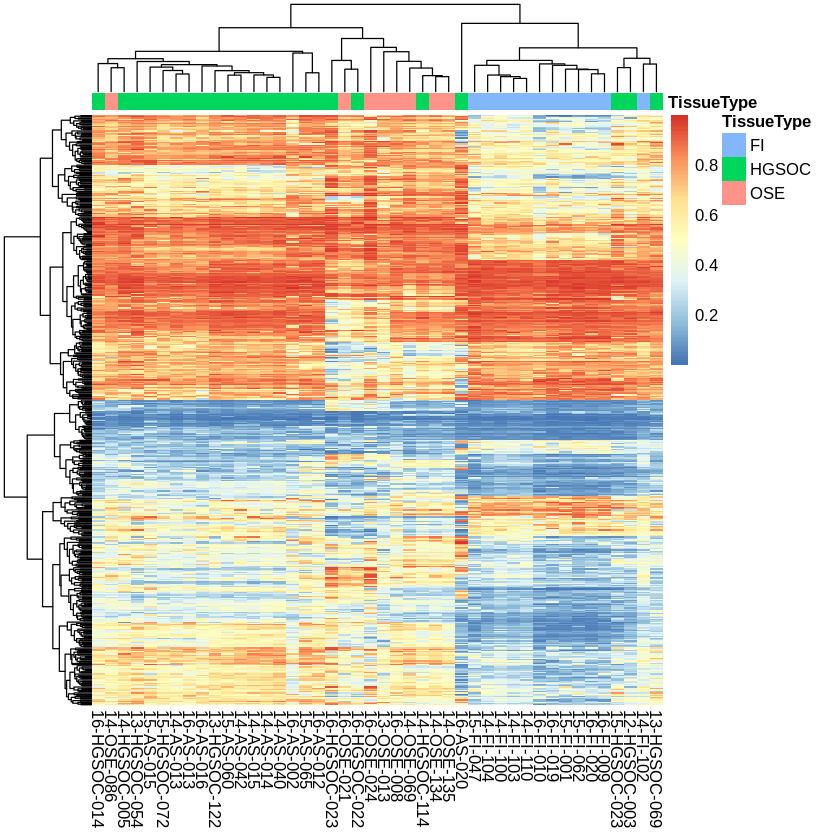

In [9]:
AnnoGroups = Annotation[,c("ID","TissueType")]
rownames(AnnoGroups) = AnnoGroups$ID
AnnoGroups$ID = NULL
pheatmap(m2beta(DatasetByOriPrint[1:500,]), annotation = AnnoGroups, show_rownames = F)

In [10]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS: /root/RVersion/R3.5/lib/R/lib/libRblas.so
LAPACK: /root/RVersion/R3.5/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] pheatmap_1.0.12     lumi_2.34.0         Biobase_2.42.0     
[4] BiocGenerics_0.28.0 limma_3.38.3       

loaded via a namespace (and not attached):
  [1] colorspace_1.4-0            siggenes_1.56.0            
  [3] mclust_5.4.2                IRdisplay_0.7.0       